# Deep Learning Assignment 2 - Part B
## Declan Stockdale

### Mobilenet proved to be the best model out of nasnset, inception and mobilenet

In [86]:
# imports


# tensorflow imports
import tensorflow as tf
from tensorflow.keras.applications import inception_resnet_v2,InceptionResNetV2, mobilenet_v3,MobileNetV3Small, nasnet, NASNetMobile
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense

# other imports
import os.path
import pathlib

# sklearn and plotting imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,f1_score,precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# image manipulation imports
import cv2 as cv

## Functions

In [70]:
# select metric for plotting (accuracy, val_accuracy, loss, val_loss)
# plots metric for each model
# hardcoded

def make_plots_of_frozen_models(metric):
    plt.plot(history_final_model_freeze_all.history[metric])
    plt.plot(history_final_model_freeze_50.history[metric])
    plt.plot(history_final_model_freeze_40.history[metric])
    plt.plot(history_final_model_freeze_30.history[metric])
    plt.plot(history_final_model_freeze_20.history[metric])
    plt.plot(history_final_model_freeze_10.history[metric])
    plt.plot(history_final_model_freeze_5.history[metric])
    
    if "_" in metric:
        metric = metric.replace("_", " ")
        
    plt.title(metric +' of all models')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['All', '50', "40", "30", "20", "10", "5"], loc='lower right')
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.show()

In [71]:
# create function for generating classification report from sklearn
# sklearn format is a string, I want a dataframe to sort the various metrics by
# splits string output gets relevant split number
# values are then stored in a dictionary and converted to a df as its cheaper than appending to a df

def classification_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[len(row_data)-5]
        row['precision'] = float(row_data[len(row_data)-4])
        row['recall'] = float(row_data[len(row_data)-3])
        row['f1_score'] = float(row_data[len(row_data)-2])
        row['support'] = float(row_data[len(row_data)-1])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.columns = ["label", "precision", "recall", "f1_score","support"]
    return dataframe

In [2]:
# set file path to local directory
folder_path=("C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/food-101/")

### Get training files

In [3]:
# training files are in a txt file in /food-101/meta/train.txt

train_file = open(folder_path+'/food-101/meta/train.txt','r')

# read contents of txt file
train_contents = train_file.read()
train_contents = list(train_contents.split('\n'))

# set empty lists 
training_label = []
training_id = []

# split and append filepath and image id ( output is ...../caprese/123
# split by / results in final two values as caprese and 123
# filepath is input to string using the output
for value in train_contents[:-2]:
  label,img_id = value.split('/')
  training_label.append(label)
  training_id.append(folder_path+'/food-101/images/'+label+'/'+img_id+'.jpg')

# close txt file
train_file.close()

In [4]:
# concateate into one dataframe with filepath and label

# series of filepaths
training_filepaths = pd.Series(training_id, name = 'filepath').astype(str)

#series of labels
training_label = pd.Series(training_label , name = 'label')

# concat the two series
train_df = pd.concat([training_filepaths, training_label], axis = 1)

### Get testing files

In [5]:
# same process as with training files

# open test txt
test_file = open(folder_path+'/food-101/meta/test.txt', "r")
test_contents = test_file.read()
test_contents = list(test_contents.split('\n'))

# empty list
test_label = []
test_id = []

# split by /, last two elements are label and image id respectively
# append output to the lists

for value in test_contents[:-2]:
  label,img_id = value.split('/')
  test_label.append(label)
  test_id.append(folder_path+'/food-101/images/'+label+'/'+img_id+'.jpg')

# close the file
test_file.close()

In [6]:
# concat into one dataframe with filepath and label using pandas series
test_filepaths = pd.Series(test_id, name = 'filepath').astype(str)
test_label = pd.Series(test_label , name = 'label')
test_df = pd.concat([test_filepaths, test_label], axis = 1)

### Shuffle datasets

In [7]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Generators

In [8]:
# create generators uning preprocessing input of mobilenetv3

mobilenet_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split = 0.2
)

mobilenet_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input
)

In [9]:
# Feed train/val and test dataframe through generatorsusing relevant parameters
# class mode is categorical
# need to specify subsets due to earlier trin split
# batch size kept at 32 same as earlier in Part A

# train set
mobilenet_train = mobilenet_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

# val set
mobilenet_val = mobilenet_train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

# test set
mobilenet_test = mobilenet_test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15149 validated image filenames belonging to 101 classes.
Found 25249 validated image filenames belonging to 101 classes.


## Building models

## Unfreeze last 50 layers

### Callbacks

In [10]:
# Early stopping set to monitor validation loss with patience of 10
early_stoping_cb = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights = True)

# reduce learning rate if it plateaus after 5 steps
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00000001)

# set checkpoint save path
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_50"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [11]:
# import model leaving top layer out
mobilenet_pretrained_freeze_50 = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# set so only last 50 layers are trainabe
for layer in mobilenet_pretrained_freeze_50.layers[-50:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_50.layers[:-50]:
    #print(layer)
    layer.trainable = False    

In [12]:
# add top layers to above model 
final_model_freeze_50 = tf.keras.Sequential([
    mobilenet_pretrained_freeze_50,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [13]:
final_model_freeze_50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1000)             2554968   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 101)               25957     
                                                                 
Total params: 2,902,973
Trainable params: 2,536,493
Non-trainable params: 366,480
_________________________________________________________________


In [14]:
final_model_freeze_50.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

history_final_model_freeze_50 = final_model_freeze_50.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 299s 154ms/step - loss: 3.9710 - accuracy: 0.0800 - val_loss: 3.4493 - val_accuracy: 0.1189 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 266s 140ms/step - loss: 3.2429 - accuracy: 0.1566 - val_loss: 3.0462 - val_accuracy: 0.2025 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 257s 135ms/step - loss: 2.8640 - accuracy: 0.2365 - val_loss: 2.7313 - val_accuracy: 0.2793 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 257s 136ms/step - loss: 2.5654 - accuracy: 0.3085 - val_loss: 2.5329 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 257s 136ms/step - loss: 2.3283 - accuracy: 0.3675 - val_loss: 2.3766 - val_accuracy: 0.3742 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 258s 136ms/step - loss: 2.1510 - accuracy: 0.4110 - val_loss: 2.3108 - val_accuracy: 0.4005 - lr: 1.0000e-04
Epoc

## Accuracy on test set

In [61]:
# Look at accuracy
mobilenet_50_results = final_model_freeze_50.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 last 50 layers unfrozen {:.2f}%'.format(mobilenet_50_results[1]*100))  

790/790 [==============================] - 98s 124ms/step - loss: 1.7696 - accuracy: 0.5566
Test set accuracy MobileNet v3 last 50 layers unfrozen 55.66%


### Predictions

In [69]:
# use argmax to get predictions
mobilenet_50_predictions = np.argmax(final_model_freeze_50.predict(mobilenet_test), axis = 1) 

## Unfreeze last 40 layers

In [15]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_40"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [16]:
# import model leaving top layer out
mobilenet_pretrained_freeze_40 = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# Only allow last 40 layers to train
for layer in mobilenet_pretrained_freeze_40.layers[-40:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_40.layers[:-40]:
    #print(layer)
    layer.trainable = False    

In [17]:
# add top layers to above model
final_model_freeze_40 = tf.keras.Sequential([
    mobilenet_pretrained_freeze_40,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [18]:
final_model_freeze_40.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1000)             2554968   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 256)               256256    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 101)               25957     
                                                                 
Total params: 2,902,973
Trainable params: 2,314,397
Non-trainable params: 588,576
_________________________________________________________________


In [19]:
# compile model
final_model_freeze_40.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model
history_final_model_freeze_40 = final_model_freeze_40.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 265s 139ms/step - loss: 3.9935 - accuracy: 0.1033 - val_loss: 3.3664 - val_accuracy: 0.1710 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 256s 135ms/step - loss: 3.1486 - accuracy: 0.1941 - val_loss: 2.9233 - val_accuracy: 0.2390 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 256s 135ms/step - loss: 2.7888 - accuracy: 0.2636 - val_loss: 2.6747 - val_accuracy: 0.2896 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 261s 138ms/step - loss: 2.5426 - accuracy: 0.3179 - val_loss: 2.5111 - val_accuracy: 0.3385 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 259s 137ms/step - loss: 2.3510 - accuracy: 0.3684 - val_loss: 2.3778 - val_accuracy: 0.3788 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 257s 136ms/step - loss: 2.1844 - accuracy: 0.4088 - val_loss: 2.3151 - val_accuracy: 0.3991 - lr: 1.0000e-04
Epoc

### Accuracy on test set

In [62]:
# Look at accuracy
mobilenet_40_results = final_model_freeze_40.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 last 40 layers unfrozen {:.2f}%'.format(mobilenet_40_results[1]*100)) 

790/790 [==============================] - 86s 107ms/step - loss: 1.6473 - accuracy: 0.5861
Test set accuracy MobileNet v3 last 40 layers unfrozen 58.61%


### Predictions

In [79]:
# use argmax to get predictions
mobilenet_40_predictions = np.argmax(final_model_freeze_40.predict(mobilenet_test), axis = 1) 

## Unfreeze last 30 layers

In [20]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_30"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [21]:
# import model leaving top layer out
mobilenet_pretrained_freeze_30 = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# only allow last 30 layers to be trained
for layer in mobilenet_pretrained_freeze_30.layers[-30:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_30.layers[:-30]:
    #print(layer)
    layer.trainable = False    

In [22]:
# add top layer to previous model
final_model_freeze_30 = tf.keras.Sequential([
    mobilenet_pretrained_freeze_30,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [23]:
final_model_freeze_30.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1000)             2554968   
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 256)               256256    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 101)               25957     
                                                                 
Total params: 2,902,973
Trainable params: 2,242,397
Non-trainable params: 660,576
_________________________________________________________________


In [24]:
# cmompile model
final_model_freeze_30.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model
history_final_model_freeze_30 = final_model_freeze_30.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 267s 140ms/step - loss: 3.9903 - accuracy: 0.0842 - val_loss: 3.4385 - val_accuracy: 0.1329 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 255s 135ms/step - loss: 3.2711 - accuracy: 0.1592 - val_loss: 3.0654 - val_accuracy: 0.2003 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 253s 134ms/step - loss: 2.9293 - accuracy: 0.2250 - val_loss: 2.8313 - val_accuracy: 0.2516 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 257s 136ms/step - loss: 2.6893 - accuracy: 0.2766 - val_loss: 2.6604 - val_accuracy: 0.2918 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 251s 133ms/step - loss: 2.4921 - accuracy: 0.3251 - val_loss: 2.5048 - val_accuracy: 0.3365 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 256s 135ms/step - loss: 2.3328 - accuracy: 0.3661 - val_loss: 2.4049 - val_accuracy: 0.3672 - lr: 1.0000e-04
Epoc

### Accuracy on test set

In [63]:
# Look at accuracy
mobilenet_30_results = final_model_freeze_30.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 last 30 layers unfrozen {:.2f}%'.format(mobilenet_30_results[1]*100)) 

790/790 [==============================] - 86s 108ms/step - loss: 1.7004 - accuracy: 0.5752
Test set accuracy MobileNet v3 last 30 layers unfrozen 57.52%


### Predictions

In [80]:
# use argmax to get predictions
mobilenet_30_predictions = np.argmax(final_model_freeze_30.predict(mobilenet_test), axis = 1) 

## Unfreeze last 20 layers

In [25]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_20"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [26]:
# import model leaving top layer out
mobilenet_pretrained_freeze_20 = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# only allow last 20 layers to eb trained
for layer in mobilenet_pretrained_freeze_20.layers[-20:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_20.layers[:-20]:
    #print(layer)
    layer.trainable = False    

In [27]:
# Add top layer to previous model
final_model_freeze_20 = tf.keras.Sequential([
    mobilenet_pretrained_freeze_20,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [28]:
final_model_freeze_20.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1000)             2554968   
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 256)               256256    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 101)               25957     
                                                                 
Total params: 2,902,973
Trainable params: 2,075,789
Non-trainable params: 827,184
_________________________________________________________________


In [29]:
# compile model
final_model_freeze_20.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model
history_final_model_freeze_20 = final_model_freeze_20.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 264s 138ms/step - loss: 4.0084 - accuracy: 0.0892 - val_loss: 3.4696 - val_accuracy: 0.1323 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 251s 133ms/step - loss: 3.3029 - accuracy: 0.1589 - val_loss: 3.0692 - val_accuracy: 0.2057 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 254s 134ms/step - loss: 2.9638 - accuracy: 0.2230 - val_loss: 2.8495 - val_accuracy: 0.2485 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 252s 133ms/step - loss: 2.7337 - accuracy: 0.2742 - val_loss: 2.6523 - val_accuracy: 0.2978 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 253s 134ms/step - loss: 2.5201 - accuracy: 0.3279 - val_loss: 2.5056 - val_accuracy: 0.3391 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 255s 135ms/step - loss: 2.3522 - accuracy: 0.3715 - val_loss: 2.3953 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoc

## Accuracy on test set

In [64]:
# Look at accuracy
mobilenet_20_results = final_model_freeze_20.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 last 20 layers unfrozen {:.2f}%'.format(mobilenet_20_results[1]*100)) 

790/790 [==============================] - 86s 108ms/step - loss: 1.5938 - accuracy: 0.6083
Test set accuracy MobileNet v3 last 20 layers unfrozen 60.83%


### Predictions

In [81]:
# use argmax to get predictions
mobilenet_20_predictions = np.argmax(final_model_freeze_20.predict(mobilenet_test), axis = 1) 

## Unfreeze last 10 layers

In [30]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_10"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [31]:
# import model leaving top layer out
mobilenet_pretrained_freeze_10 = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# only allow last 10 layers to be trained
for layer in mobilenet_pretrained_freeze_10.layers[-10:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_10.layers[:-10]:
    #print(layer)
    layer.trainable = False    

In [32]:
# Add top layers to model
final_model_freeze_10 = tf.keras.Sequential([
    mobilenet_pretrained_freeze_10,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [33]:
#final_model_freeze_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1000)             2554968   
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 256)               256256    
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 101)               25957     
                                                                 
Total params: 2,902,973
Trainable params: 1,963,853
Non-trainable params: 939,120
_________________________________________________________________


In [34]:
# compile model
final_model_freeze_10.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model
history_final_model_freeze_10 = final_model_freeze_10.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 252s 132ms/step - loss: 3.9842 - accuracy: 0.0869 - val_loss: 3.5094 - val_accuracy: 0.1211 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 259s 137ms/step - loss: 3.3639 - accuracy: 0.1415 - val_loss: 3.2161 - val_accuracy: 0.1719 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 263s 139ms/step - loss: 3.0924 - accuracy: 0.1977 - val_loss: 2.9873 - val_accuracy: 0.2312 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 258s 136ms/step - loss: 2.8654 - accuracy: 0.2533 - val_loss: 2.8017 - val_accuracy: 0.2787 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 259s 137ms/step - loss: 2.6728 - accuracy: 0.3021 - val_loss: 2.6529 - val_accuracy: 0.3246 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 254s 134ms/step - loss: 2.5102 - accuracy: 0.3423 - val_loss: 2.5292 - val_accuracy: 0.3503 - lr: 1.0000e-04
Epoc

## Accuracy on test set

In [65]:
# Look at accuracy
mobilenet_10_results = final_model_freeze_10.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 last 10 layers unfrozen {:.2f}%'.format(mobilenet_10_results[1]*100)) 

790/790 [==============================] - 85s 107ms/step - loss: 1.7148 - accuracy: 0.5710
Test set accuracy MobileNet v3 last 10 layers unfrozen 57.10%


### Predictions

In [82]:
# use argmax to get predictions
mobilenet_10_predictions = np.argmax(final_model_freeze_10.predict(mobilenet_test), axis = 1) 

## Unfreeze last 5 layers

In [35]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_5"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [36]:
# import model leaving top layer out
mobilenet_pretrained_freeze_5= MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# only allow last 5 layes to be trained
for layer in mobilenet_pretrained_freeze_5.layers[-5:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_5.layers[:-5]:
    #print(layer)
    layer.trainable = False    

In [37]:
# add top layers
final_model_freeze_5 = tf.keras.Sequential([
    mobilenet_pretrained_freeze_5,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [39]:
# compile model
final_model_freeze_5.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)
# fit model
history_final_model_freeze_5 = final_model_freeze_5.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 261s 137ms/step - loss: 3.9825 - accuracy: 0.1192 - val_loss: 3.4333 - val_accuracy: 0.1628 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 258s 136ms/step - loss: 3.2858 - accuracy: 0.1937 - val_loss: 3.1378 - val_accuracy: 0.2147 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 254s 134ms/step - loss: 3.0565 - accuracy: 0.2364 - val_loss: 2.9650 - val_accuracy: 0.2526 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 253s 134ms/step - loss: 2.9046 - accuracy: 0.2664 - val_loss: 2.8403 - val_accuracy: 0.2763 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 250s 132ms/step - loss: 2.7844 - accuracy: 0.2932 - val_loss: 2.7423 - val_accuracy: 0.3048 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 252s 133ms/step - loss: 2.6738 - accuracy: 0.3204 - val_loss: 2.6480 - val_accuracy: 0.3281 - lr: 1.0000e-04
Epoc

## Accuracy on test set

In [66]:
# Look at accuracy
mobilenet_5_results = final_model_freeze_5.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 last 5 layers unfrozen {:.2f}%'.format(mobilenet_5_results[1]*100)) 

790/790 [==============================] - 85s 107ms/step - loss: 1.5942 - accuracy: 0.5991
Test set accuracy MobileNet v3 last 5 layers unfrozen 59.91%


### Predictions

In [83]:
# use argmax to get predictions
mobilenet_5_predictions = np.argmax(final_model_freeze_5.predict(mobilenet_test), axis = 1) 

# New model  with all layers trainable

In [40]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_all"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [41]:
# import model leaving top layer out
mobilenet_pretrained_freeze_all= MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# all layers trainable
for layer in mobilenet_pretrained_freeze_all.layers:
    layer.trainable = True
 

In [42]:
# add top layers
final_model_freeze_all = tf.keras.Sequential([
    mobilenet_pretrained_freeze_all,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [43]:
#final_model_freeze_all.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1000)             2554968   
 l)                                                              
                                                                 
 dense_18 (Dense)            (None, 256)               256256    
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 101)               25957     
                                                                 
Total params: 2,902,973
Trainable params: 2,890,861
Non-trainable params: 12,112
_________________________________________________________________


In [44]:
# compile model 
final_model_freeze_all.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model 
history_final_model_freeze_all = final_model_freeze_all.fit(
    mobilenet_train,
    validation_data = mobilenet_val,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 267s 139ms/step - loss: 4.0154 - accuracy: 0.0934 - val_loss: 3.4408 - val_accuracy: 0.1414 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 267s 141ms/step - loss: 3.1856 - accuracy: 0.1771 - val_loss: 2.9703 - val_accuracy: 0.2189 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 258s 136ms/step - loss: 2.7760 - accuracy: 0.2555 - val_loss: 2.6944 - val_accuracy: 0.2784 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 265s 140ms/step - loss: 2.4814 - accuracy: 0.3175 - val_loss: 2.5129 - val_accuracy: 0.3243 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 259s 137ms/step - loss: 2.2463 - accuracy: 0.3736 - val_loss: 2.3645 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 264s 139ms/step - loss: 2.0454 - accuracy: 0.4263 - val_loss: 2.2634 - val_accuracy: 0.4112 - lr: 1.0000e-04
Epoc

## Accuracy on test set

In [67]:
# Look at accuracy
mobilenet_all_results = final_model_freeze_all.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 all layers unfrozen {:.2f}%'.format(mobilenet_all_results[1]*100)) 

790/790 [==============================] - 86s 108ms/step - loss: 1.6530 - accuracy: 0.5863
Test set accuracy MobileNet v3 all layers unfrozen 58.63%


### Predictions

In [74]:
# use argmax to get predictions
mobilenet_all_predictions = np.argmax(final_model_freeze_all.predict(mobilenet_test), axis = 1) 

## Accuracy on all models on test set

In [68]:
print('Test set accuracy MobileNet v3 all layers unfrozen  {:.2f}%'.format(mobilenet_all_results[1]*100))  
print('Test set accuracy MobileNet v3 last 50 layers unfrozen {:.2f}%'.format(mobilenet_50_results[1]*100))  
print('Test set accuracy MobileNet v3 last 40 layers unfrozen {:.2f}%'.format(mobilenet_40_results[1]*100))  
print('Test set accuracy MobileNet v3 last 30 layers unfrozen {:.2f}%'.format(mobilenet_30_results[1]*100)) 
print('Test set accuracy MobileNet v3 last 20 layers unfrozen {:.2f}%'.format(mobilenet_20_results[1]*100)) 
print('Test set accuracy MobileNet v3 last 10 layers unfrozen {:.2f}%'.format(mobilenet_10_results[1]*100)) 
print('Test set accuracy MobileNet v3 last 5 layers unfrozen {:.2f}%'.format(mobilenet_5_results[1]*100)) 

Test set accuracy MobileNet v3 all layers unfrozen  58.63%
Test set accuracy MobileNet v3 last 50 layers unfrozen 55.66%
Test set accuracy MobileNet v3 last 40 layers unfrozen 58.61%
Test set accuracy MobileNet v3 last 30 layers unfrozen 57.52%
Test set accuracy MobileNet v3 last 20 layers unfrozen 60.83%
Test set accuracy MobileNet v3 last 10 layers unfrozen 57.10%
Test set accuracy MobileNet v3 last 5 layers unfrozen 59.91%


### F1 Score for each model

In [91]:
mobilenet_all_f1 = f1_score(mobilenet_test.labels, mobilenet_all_predictions,average='macro')
mobilenet_50_f1 = f1_score(mobilenet_test.labels, mobilenet_50_predictions,average='macro')
mobilenet_40_f1 = f1_score(mobilenet_test.labels, mobilenet_40_predictions,average='macro')
mobilenet_30_f1 = f1_score(mobilenet_test.labels, mobilenet_30_predictions,average='macro')
mobilenet_20_f1 = f1_score(mobilenet_test.labels, mobilenet_20_predictions,average='macro')
mobilenet_10_f1 = f1_score(mobilenet_test.labels, mobilenet_10_predictions,average='macro')
mobilenet_5_f1 = f1_score(mobilenet_test.labels, mobilenet_5_predictions,average='macro')
                     
print('Test set f1 MobileNet v3 all layers unfrozen  {:.2f}'.format(mobilenet_all_f1))  
print('Test set f1 MobileNet v3 last 50 layers unfrozen  {:.2f}'.format(mobilenet_50_f1)) 
print('Test set f1 MobileNet v3 last 40 layers unfrozen  {:.2f}'.format(mobilenet_40_f1)) 
print('Test set f1 MobileNet v3 last 30 layers unfrozen  {:.2f}'.format(mobilenet_30_f1)) 
print('Test set f1 MobileNet v3 last 20 layers unfrozen  {:.2f}'.format(mobilenet_20_f1)) 
print('Test set f1 MobileNet v3 last 10 layers unfrozen  {:.2f}'.format(mobilenet_10_f1)) 
print('Test set f1 MobileNet v3 last 5 layers unfrozen  {:.2f}'.format(mobilenet_5_f1)) 
                   

Test set f1 MobileNet v3 all layers unfrozen  0.58
Test set f1 MobileNet v3 last 50 layers unfrozen  0.55
Test set f1 MobileNet v3 last 40 layers unfrozen  0.59
Test set f1 MobileNet v3 last 30 layers unfrozen  0.57
Test set f1 MobileNet v3 last 20 layers unfrozen  0.61
Test set f1 MobileNet v3 last 10 layers unfrozen  0.57
Test set f1 MobileNet v3 last 5 layers unfrozen  0.60


#### Recall of all models

In [89]:
mobilenet_all_recall = recall_score(mobilenet_test.labels, mobilenet_all_predictions,average='macro')
mobilenet_50_recall = recall_score(mobilenet_test.labels, mobilenet_50_predictions,average='macro')
mobilenet_40_recall = recall_score(mobilenet_test.labels, mobilenet_40_predictions,average='macro')
mobilenet_30_recall = recall_score(mobilenet_test.labels, mobilenet_30_predictions,average='macro')
mobilenet_20_recall = recall_score(mobilenet_test.labels, mobilenet_20_predictions,average='macro')
mobilenet_10_recall = recall_score(mobilenet_test.labels, mobilenet_10_predictions,average='macro')
mobilenet_5_recall = recall_score(mobilenet_test.labels, mobilenet_5_predictions,average='macro')
                     
print('Test set recall MobileNet v3 all layers unfrozen  {:.2f}'.format(mobilenet_all_recall))  
print('Test set recall MobileNet v3 last 50 layers unfrozen  {:.2f}'.format(mobilenet_50_recall)) 
print('Test set recall MobileNet v3 last 40 layers unfrozen  {:.2f}'.format(mobilenet_40_recall)) 
print('Test set recall MobileNet v3 last 30 layers unfrozen  {:.2f}'.format(mobilenet_30_recall)) 
print('Test set recall MobileNet v3 last 20 layers unfrozen  {:.2f}'.format(mobilenet_20_recall)) 
print('Test set recall MobileNet v3 last 10 layers unfrozen  {:.2f}'.format(mobilenet_10_recall)) 
print('Test set recall MobileNet v3 last 5 layers unfrozen  {:.2f}'.format(mobilenet_5_recall))

Test set recall MobileNet v3 all layers unfrozen  0.59
Test set recall MobileNet v3 last 50 layers unfrozen  0.56
Test set recall MobileNet v3 last 40 layers unfrozen  0.59
Test set recall MobileNet v3 last 30 layers unfrozen  0.58
Test set recall MobileNet v3 last 20 layers unfrozen  0.61
Test set recall MobileNet v3 last 10 layers unfrozen  0.57
Test set recall MobileNet v3 last 5 layers unfrozen  0.60


#### Precision of all models

In [90]:
mobilenet_all_precision = precision_score(mobilenet_test.labels, mobilenet_all_predictions,average='macro')
mobilenet_50_precision = precision_score(mobilenet_test.labels, mobilenet_50_predictions,average='macro')
mobilenet_40_precision = precision_score(mobilenet_test.labels, mobilenet_40_predictions,average='macro')
mobilenet_30_precision = precision_score(mobilenet_test.labels, mobilenet_30_predictions,average='macro')
mobilenet_20_precision = precision_score(mobilenet_test.labels, mobilenet_20_predictions,average='macro')
mobilenet_10_precision = precision_score(mobilenet_test.labels, mobilenet_10_predictions,average='macro')
mobilenet_5_precision = precision_score(mobilenet_test.labels, mobilenet_5_predictions,average='macro')
                     
print('Test set precision MobileNet v3 all layers unfrozen  {:.2f}'.format(mobilenet_all_precision))  
print('Test set precision MobileNet v3 last 50 layers unfrozen  {:.2f}'.format(mobilenet_50_precision)) 
print('Test set precision MobileNet v3 last 40 layers unfrozen  {:.2f}'.format(mobilenet_40_precision)) 
print('Test set precision MobileNet v3 last 30 layers unfrozen  {:.2f}'.format(mobilenet_30_precision)) 
print('Test set precision MobileNet v3 last 20 layers unfrozen  {:.2f}'.format(mobilenet_20_precision)) 
print('Test set precision MobileNet v3 last 10 layers unfrozen  {:.2f}'.format(mobilenet_10_precision)) 
print('Test set precision MobileNet v3 last 5 layers unfrozen  {:.2f}'.format(mobilenet_5_precision))


Test set precision MobileNet v3 all layers unfrozen  0.59
Test set precision MobileNet v3 last 50 layers unfrozen  0.56
Test set precision MobileNet v3 last 40 layers unfrozen  0.59
Test set precision MobileNet v3 last 30 layers unfrozen  0.58
Test set precision MobileNet v3 last 20 layers unfrozen  0.62
Test set precision MobileNet v3 last 10 layers unfrozen  0.57
Test set precision MobileNet v3 last 5 layers unfrozen  0.60


### Plot results of all models

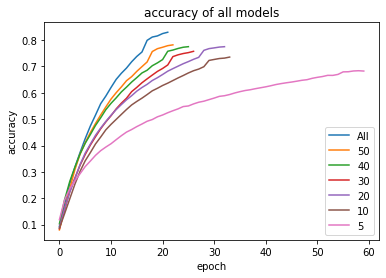

In [58]:
# plot train accuracy
make_plots_of_frozen_models('accuracy')

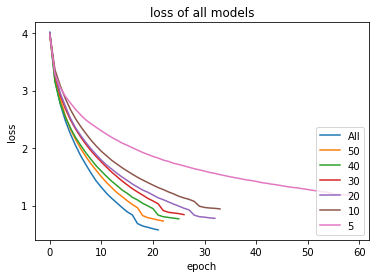

In [50]:
# plot train loss
make_plots_of_frozen_models('loss')

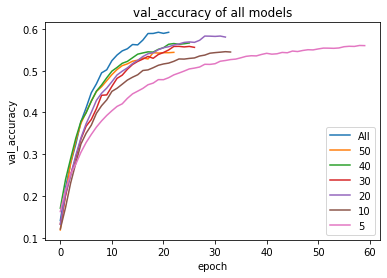

In [49]:
# plot validatio accuracy
make_plots_of_frozen_models("val_accuracy")

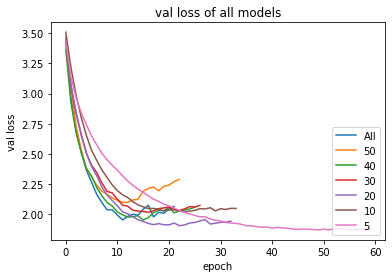

In [59]:
# plot validation loss
make_plots_of_frozen_models("val_loss")

### Confusion matrix of best model (20 layers unfrozen)

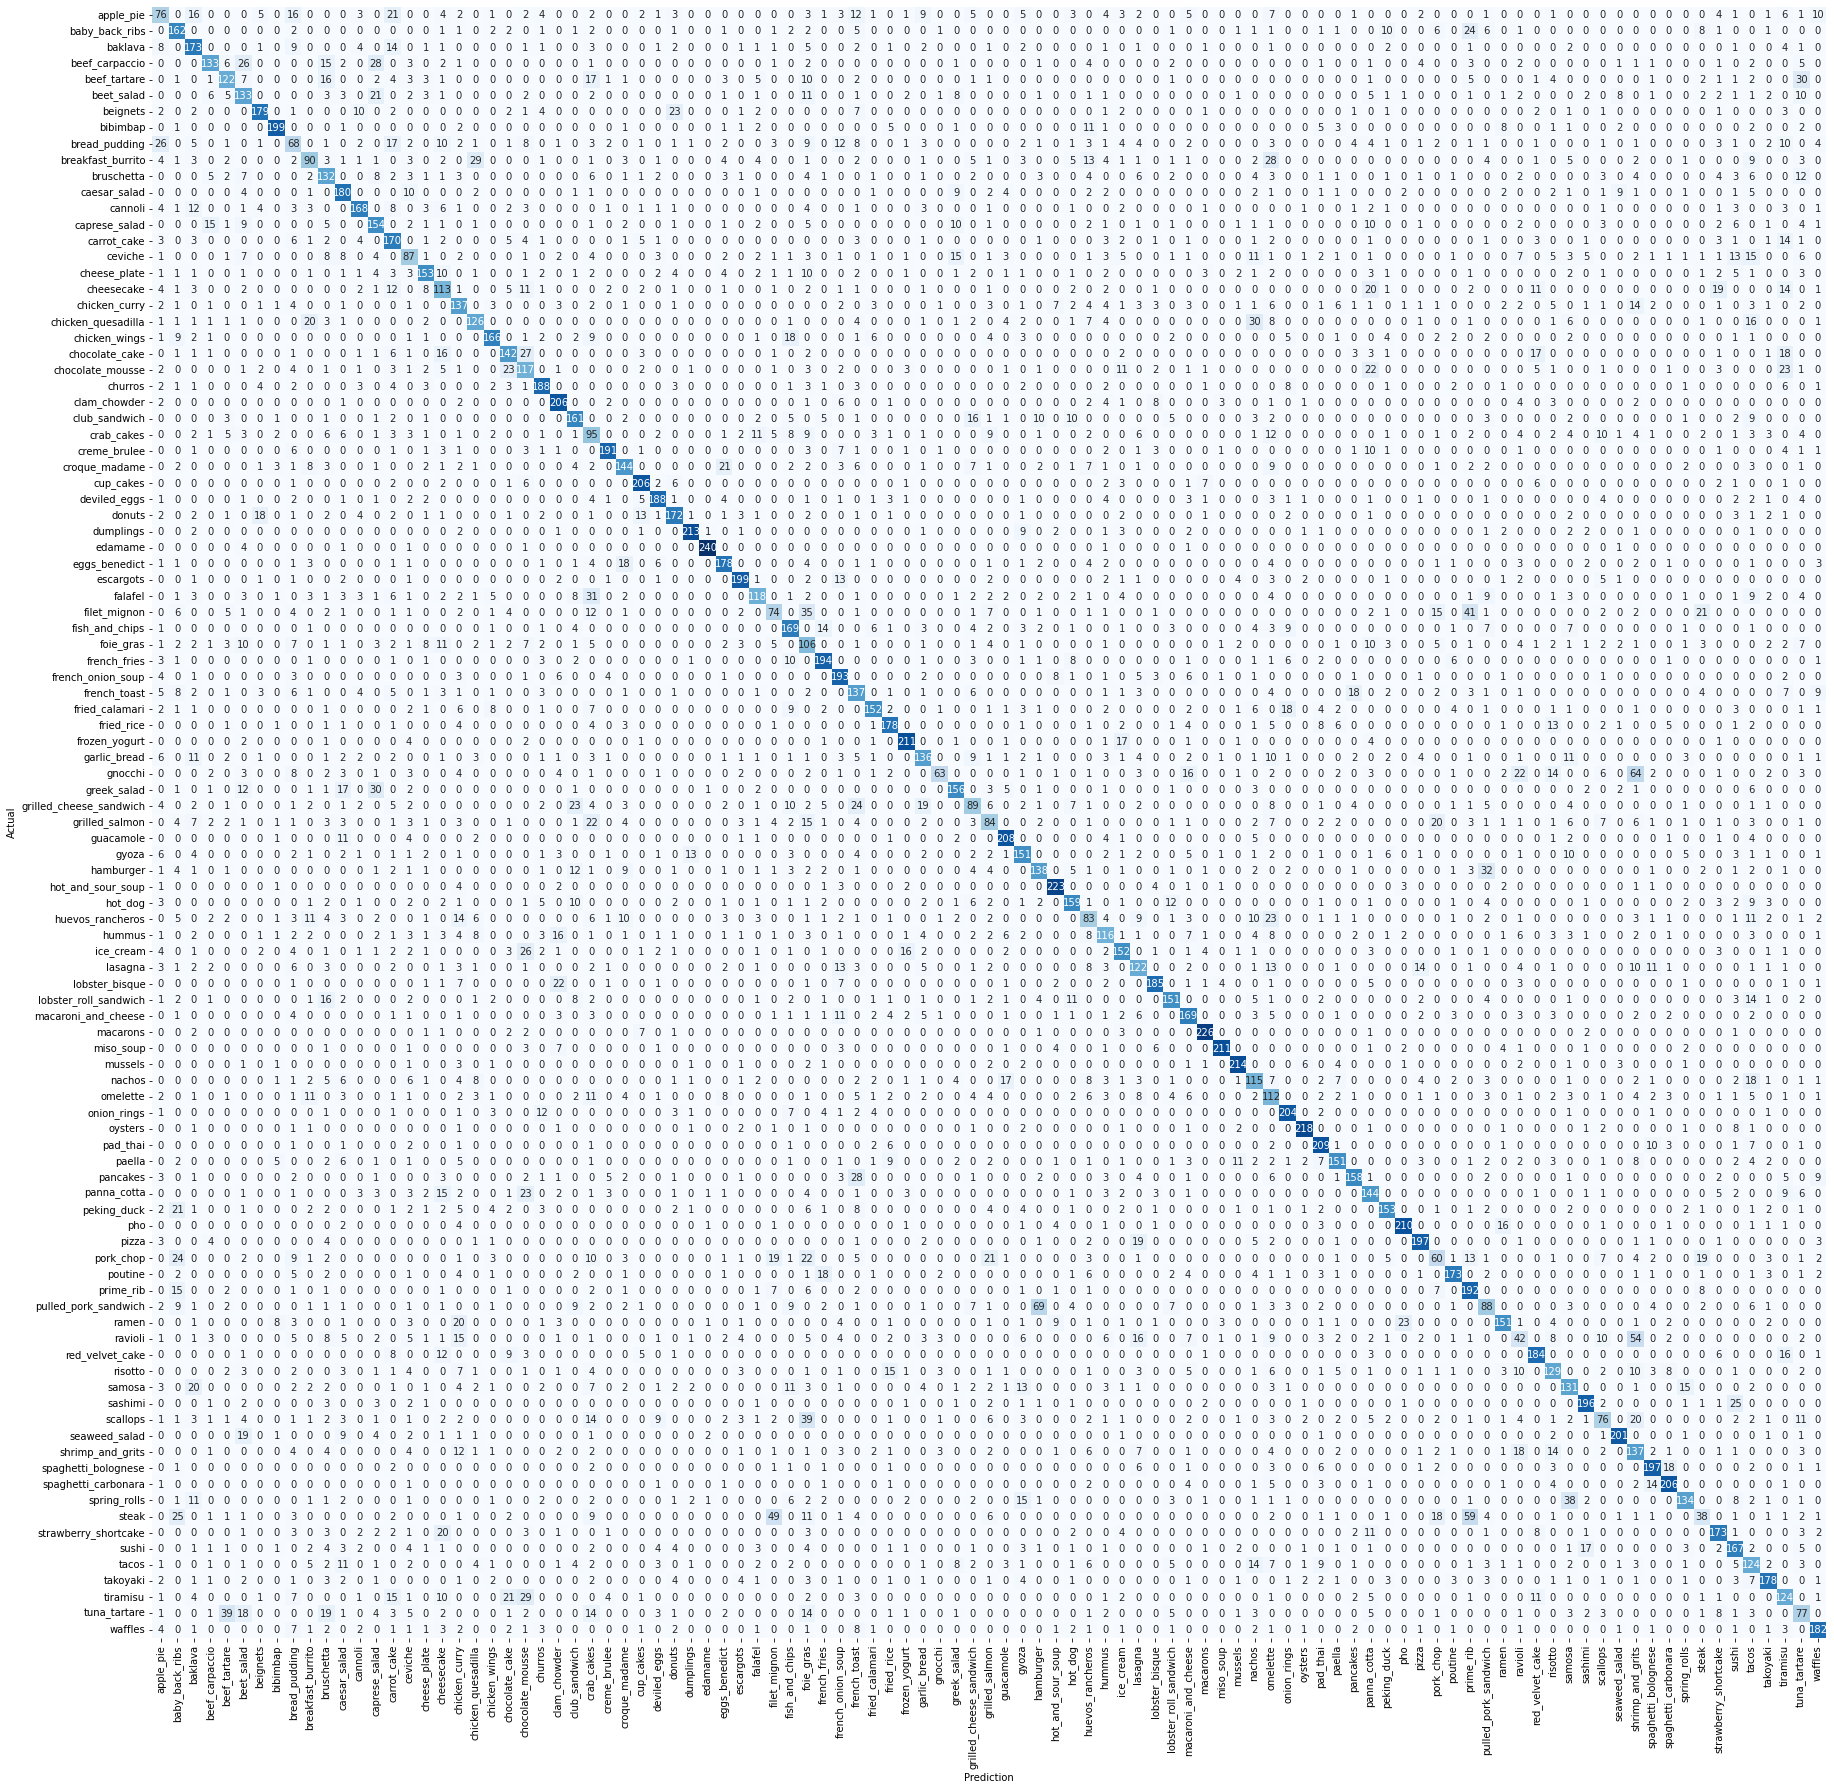

In [96]:
mobilenet_20_conf_matrix = confusion_matrix(mobilenet_test.labels,mobilenet_20_predictions)

# create heatmap

plt.figure(figsize = (30,30))
sns.heatmap(mobilenet_20_conf_matrix, vmin=0, annot = True, fmt = 'g', cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(101)+0.5, labels=mobilenet_test.class_indices, rotation = 90)
plt.yticks(ticks = np.arange(101)+0.5, labels=mobilenet_test.class_indices, rotation = 0)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

### Look at classification report

In [97]:
# generate report using sklearn
mobilenet_20_report = classification_report(mobilenet_test.labels, mobilenet_20_predictions, target_names=mobilenet_test.class_indices)
# convert report to dataframe
mobilenet_20_clr_df = classification_report_df(mobilenet_20_report)

In [102]:
mobilenet_20_clr_df.sort_values(['f1_score'],ascending = False).reset_index(drop=True).head(10)

,label,precision,recall,f1_score,support
0,edamame,0.97,0.96,0.96,250.0
1,macarons,0.88,0.90,0.89,250.0
2,oysters,0.90,0.87,0.89,250.0
3,miso_soup,0.93,0.84,0.88,250.0
4,dumplings,0.88,0.85,0.87,250.0
5,hot_and_sour_soup,0.84,0.89,0.87,250.0
6,mussels,0.86,0.86,0.86,250.0
7,pho,0.85,0.84,0.85,250.0
8,frozen_yogurt,0.83,0.84,0.84,250.0
9,seaweed_salad,0.86,0.80,0.83,250.0


In [103]:
mobilenet_20_clr_df.sort_values(['f1_score'],ascending = True).reset_index(drop=True).head(10)

,label,precision,recall,f1_score,support
0,ravioli,0.26,0.17,0.20,250.0
1,steak,0.32,0.15,0.21,250.0
2,bread_pudding,0.28,0.27,0.28,250.0
3,pork_chop,0.40,0.24,0.30,250.0
4,crab_cakes,0.27,0.38,0.31,250.0
5,tuna_tartare,0.33,0.31,0.32,250.0
6,foie_gras,0.26,0.42,0.32,250.0
7,apple_pie,0.35,0.30,0.33,250.0
8,filet_mignon,0.40,0.30,0.34,250.0
9,huevos_rancheros,0.38,0.33,0.35,250.0


## Try best model ( 20 layers unfrozen) with data augmentation

In [104]:
# create generators uning preprocessing input of mobilenetv3

mobilenet_train_generator_data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split = 0.2, 
    rotation_range = 20, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True
)

mobilenet_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input
)

In [105]:
# Feed train/val and test dataframe through generatorsusing relevant parameters
# class mode is categorical
# need to specify subsets due to earlier trin split
# batch size kept at 32 same as earlier in Part A

# train set
mobilenet_train_data_augmentation = mobilenet_train_generator_data_augmentation.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

# val set
mobilenet_val_data_augmentation = mobilenet_train_generator_data_augmentation.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

# test set
mobilenet_test = mobilenet_test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepath',
    y_col = 'label',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15149 validated image filenames belonging to 101 classes.
Found 25249 validated image filenames belonging to 101 classes.


In [108]:
# import model leaving top layer out
mobilenet_pretrained_freeze_20_data_augmentation = MobileNetV3Small(
    input_shape = (224, 224, 3),
    include_top = 'False',
    weights = 'imagenet',
    pooling = 'max'
)

# only allow last 20 layers to eb trained
for layer in mobilenet_pretrained_freeze_20_data_augmentation.layers[-20:]:
    #print(layer)
    layer.trainable = True
    
for layer in mobilenet_pretrained_freeze_20_data_augmentation.layers[:-20]:
    #print(layer)
    layer.trainable = False    

In [109]:
# Add top layer to previous model
final_model_freeze_20_data_augmentation = tf.keras.Sequential([
    mobilenet_pretrained_freeze_20_data_augmentation,
    Dense(256, activation='relu'), # first fully connected layer
    Dense(256, activation='relu'), # second fully connected layer
    Dense(101, activation='softmax') # final output for 101 classes 
])

In [110]:
# use earlier callbacks of Reduce LR and early stopping

# set checkpoint save path as file has now changed
checkpoint_filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment2/mobilenet_finetuning_20_data_augmentation"

# set model checkpoit to save best weights
model_checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

In [ ]:
# compile model
final_model_freeze_20_data_augmentation.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy', # vector due to imagedatagenertor
    metrics = 'accuracy'
)

# fit model
history_final_model_freeze_20_data_augmentation = final_model_freeze_20_data_augmentation.fit(
    mobilenet_train_data_augmentation,
    validation_data = mobilenet_val_data_augmentation,
    epochs = 100,
    callbacks = [early_stoping_cb,reduce_lr,model_checkpoint_cb]
)

Epoch 1/100
1894/1894 [==============================] - 1014s 534ms/step - loss: 4.0710 - accuracy: 0.0838 - val_loss: 3.5857 - val_accuracy: 0.1188 - lr: 1.0000e-04
Epoch 2/100
1894/1894 [==============================] - 983s 519ms/step - loss: 3.4334 - accuracy: 0.1417 - val_loss: 3.2205 - val_accuracy: 0.1727 - lr: 1.0000e-04
Epoch 3/100
1894/1894 [==============================] - 987s 521ms/step - loss: 3.1314 - accuracy: 0.1988 - val_loss: 2.9809 - val_accuracy: 0.2304 - lr: 1.0000e-04
Epoch 4/100
1894/1894 [==============================] - 995s 525ms/step - loss: 2.9176 - accuracy: 0.2440 - val_loss: 2.8080 - val_accuracy: 0.2758 - lr: 1.0000e-04
Epoch 5/100
1894/1894 [==============================] - 991s 523ms/step - loss: 2.7532 - accuracy: 0.2829 - val_loss: 2.6633 - val_accuracy: 0.3091 - lr: 1.0000e-04
Epoch 6/100
1894/1894 [==============================] - 983s 519ms/step - loss: 2.6152 - accuracy: 0.3209 - val_loss: 2.5625 - val_accuracy: 0.3435 - lr: 1.0000e-04
Epo

## Accuracy with data augmentation

In [ ]:
# Look at accuracy
mobilenet_20_results_data_augmentation = final_model_freeze_20_data_augmentation.evaluate(mobilenet_test)
print('Test set accuracy MobileNet v3 all layers unfrozen {:.2f}%'.format(mobilenet_20_results_data_augmentation[1]*100)) 

In [ ]:
mobilenet_20_data_augmentation_recall = recall_score(mobilenet_test.labels, mobilenet_20_results_data_augmentation,average='macro')
mobilenet_20_data_augmentation_precision = precision_score(mobilenet_test.labels, mobilenet_20_results_data_augmentation,average='macro')
mobilenet_20_data_augmentation_recall = recall_score(mobilenet_test.labels, mobilenet_20_results_data_augmentation,average='macro')

print('Test set recall MobileNet v3 all layers unfrozen  {:.2f}'.format(mobilenet_20_data_augmentation_recall)) 
print('Test set precision MobileNet v3 all layers unfrozen  {:.2f}'.format(mobilenet_20_data_augmentation_precision))                      
print('Test set recall MobileNet v3 all layers unfrozen  {:.2f}'.format(mobilenet_20_data_augmentation_recall)) 